## 1: Подготовка данных

In [1]:
import pandas as pd

# Загрузка данных
df = pd.read_csv('GAZP.csv', delimiter=',', parse_dates=['Дата'], dayfirst=True)

# Преобразование столбца "Дата" в формат datetime
df['Дата'] = pd.to_datetime(df['Дата'], format='%d.%m.%Y')

# Преобразуем запятую в точку в столбце "Цена" для корректной работы с числовыми значениями
df['Цена'] = df['Цена'].str.replace(',', '.').astype(float)

# Отобразим первые несколько строк данных для проверки
df.head()


,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %
0,2024-12-23,119.74,"117,18","120,90","116,60","96,36M","3,90%"
1,2024-12-20,115.24,"107,16","116,42","106,88","155,01M","7,54%"
2,2024-12-19,107.16,"108,00","111,16","106,00","164,46M","-0,82%"
3,2024-12-18,108.05,"107,46","108,57","105,22","79,06M","0,74%"
4,2024-12-17,107.26,"108,72","109,47","106,10","67,65M","-1,33%"


### 1.2. Предобработка данных

In [2]:
# Нормализуем данные
from sklearn.preprocessing import StandardScaler

# Нормализация столбца "Цена"
scaler = StandardScaler()
df['Цена_норм'] = scaler.fit_transform(df[['Цена']])

# Добавим лаги для "Цена"
df['Цена_lag1'] = df['Цена_норм'].shift(1)
df.dropna(inplace=True)  # Удаляем строки с NaN

# Целевой признак - изменение цены
df['Целевая'] = df['Цена_норм'].shift(-1)  # Прогнозируем следующую цену
df.dropna(inplace=True)


## 2: Разделение данных на обучающую и тестовую выборки

In [3]:
from sklearn.model_selection import train_test_split

X = df[['Цена_норм', 'Цена_lag1']]
y = df['Целевая']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


## Этап 3: Обучение моделей машинного обучения

### 3.1. Логистическая регрессия

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
# Загрузка данных
df = pd.read_csv("GAZP.csv", usecols=["Дата", "Цена"])

# Преобразование столбца "Цена" в числовой формат (удаляем запятые)
df['Цена'] = df['Цена'].str.replace(',', '').astype(float)

# Проверка на наличие нечисловых значений (NaN)
if df['Цена'].isna().sum() > 0:
    print("В столбце 'Цена' есть пропущенные значения (NaN).")
    print(df[df['Цена'].isna()])

# Создание целевой переменной: 1, если цена выше средней, 0 - если ниже
avg_price = df['Цена'].mean()
df['Целевая'] = (df['Цена'] > avg_price).astype(int)

# Создание признаков (цена за предыдущий день)
df['Цена_предыдущий'] = df['Цена'].shift(1)  # Сдвигаем цену на 1 день вниз

# Удаление строк с пропущенными значениями (например, первая строка будет иметь NaN)
df = df.dropna(subset=['Цена_предыдущий'])

# Признаки и целевая переменная
X = df[['Цена_предыдущий']].values
y = df['Целевая'].values

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Нормализация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Логистическая регрессия
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred = lr.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.9811320754716981


### 3.2. Машина опорных векторов (SVM)

In [5]:
from sklearn.svm import SVR

# Обучение модели SVM
svm = SVR()
svm.fit(X_train, y_train)

# Прогнозирование на тестовых данных
y_pred_svm = svm.predict(X_test)

# Оценка модели
mse_svm = mean_squared_error(y_test, y_pred_svm)
print(f'Mean Squared Error (SVM): {mse_svm}')


Mean Squared Error (SVM): 0.016091812458289913


### 3.3. Модель случайного леса (Random Forest)

In [6]:
from sklearn.ensemble import RandomForestRegressor

# Обучение модели случайного леса
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Прогнозирование на тестовых данных
y_pred_rf = rf.predict(X_test)

# Оценка модели
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Mean Squared Error (Random Forest): {mse_rf}')


Mean Squared Error (Random Forest): 0.017499999999999998


### 3.4. Градиентный бустинг (XGBoost)

In [7]:
import xgboost as xgb

# Обучение модели XGBoost
xg = xgb.XGBRegressor()
xg.fit(X_train, y_train)

# Прогнозирование на тестовых данных
y_pred_xg = xg.predict(X_test)

# Оценка модели
mse_xg = mean_squared_error(y_test, y_pred_xg)
print(f'Mean Squared Error (XGBoost): {mse_xg}')


Mean Squared Error (XGBoost): 0.01886015136213844


## 4: Настройка гиперпараметров с помощью кросс-валидации

### 4.1. Кросс-валидация для случайного леса (Random Forest)

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Гиперпараметры для случайного леса
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Инициализация модели случайного леса
rf = RandomForestRegressor()

# Настройка GridSearchCV для кросс-валидации
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_rf.fit(X_train, y_train)

# Лучшие параметры
print(f'Best Parameters for Random Forest: {grid_rf.best_params_}')


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


### 4.2. Кросс-валидация для XGBoost

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Гиперпараметры для XGBoost
param_grid_xg = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 10, 15],
    'subsample': [0.8, 1.0]
}

# Инициализация модели XGBoost
xg = xgb.XGBRegressor()

# Настройка GridSearchCV для кросс-валидации
grid_xg = GridSearchCV(estimator=xg, param_grid=param_grid_xg, cv=5, n_jobs=-1, verbose=2)
grid_xg.fit(X_train, y_train)

# Лучшие параметры
print(f'Best Parameters for XGBoost: {grid_xg.best_params_}')


### 4.3. Кросс-валидация для машины опорных векторов (SVM)

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# Гиперпараметры для SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

# Инициализация модели SVM
svm = SVR()

# Настройка GridSearchCV для кросс-валидации
grid_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=5, n_jobs=-1, verbose=2)
grid_svm.fit(X_train, y_train)

# Лучшие параметры
print(f'Best Parameters for SVM: {grid_svm.best_params_}')


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters for SVM: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}


### 4.4. Кросс-валидация для логистической регрессии

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Гиперпараметры для логистической регрессии
param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

# Инициализация модели логистической регрессии
lr = LogisticRegression()

# Настройка GridSearchCV для кросс-валидации
grid_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=5, n_jobs=-1, verbose=2)
grid_lr.fit(X_train, y_train)

# Лучшие параметры
print(f'Best Parameters for Logistic Regression: {grid_lr.best_params_}')


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters for Logistic Regression: {'C': 0.1, 'solver': 'liblinear'}


## Этап 5: Прогнозирование на тестовой выборке

### 5.1. Логистическая регрессия

In [12]:
# Прогнозирование с использованием оптимизированных параметров
y_pred_lr = grid_lr.best_estimator_.predict(X_test)

# Оценка модели
from sklearn.metrics import mean_squared_error
mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f'Mean Squared Error (Logistic Regression): {mse_lr}')


Mean Squared Error (Logistic Regression): 0.018867924528301886


### 5.2. Машина опорных векторов (SVM)

In [13]:
# Прогнозирование с использованием оптимизированных параметров
y_pred_svm = grid_svm.best_estimator_.predict(X_test)

# Оценка модели
mse_svm = mean_squared_error(y_test, y_pred_svm)
print(f'Mean Squared Error (SVM): {mse_svm}')


Mean Squared Error (SVM): 0.016293056267503585


### 5.3. Модель случайного леса (Random Forest)

In [14]:
# Прогнозирование с использованием оптимизированных параметров
y_pred_rf = grid_rf.best_estimator_.predict(X_test)

# Оценка модели
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Mean Squared Error (Random Forest): {mse_rf}')


Mean Squared Error (Random Forest): 0.014945246278550177


### 5.4. Градиентный бустинг (XGBoost)

In [15]:
# Прогнозирование с использованием оптимизированных параметров
y_pred_xg = grid_xg.best_estimator_.predict(X_test)

# Оценка модели
mse_xg = mean_squared_error(y_test, y_pred_xg)
print(f'Mean Squared Error (XGBoost): {mse_xg}')


Mean Squared Error (XGBoost): 0.01740483928996011


## 6: Сравнение моделей

In [20]:
# Сравнение MSE моделей
mse_results = {
    'Logistic Regression': mse_lr,
    'SVM': mse_svm,
    'Random Forest': mse_rf,
    'XGBoost': mse_xg
}

# Выводим результаты
for model, mse in mse_results.items():
    print(f'{model}: Mean Squared Error = {mse}')


Logistic Regression: Mean Squared Error = 0.018867924528301886
SVM: Mean Squared Error = 0.016293056267503585
Random Forest: Mean Squared Error = 0.014945246278550177
XGBoost: Mean Squared Error = 0.01740483928996011


## Визуализация прогнозов

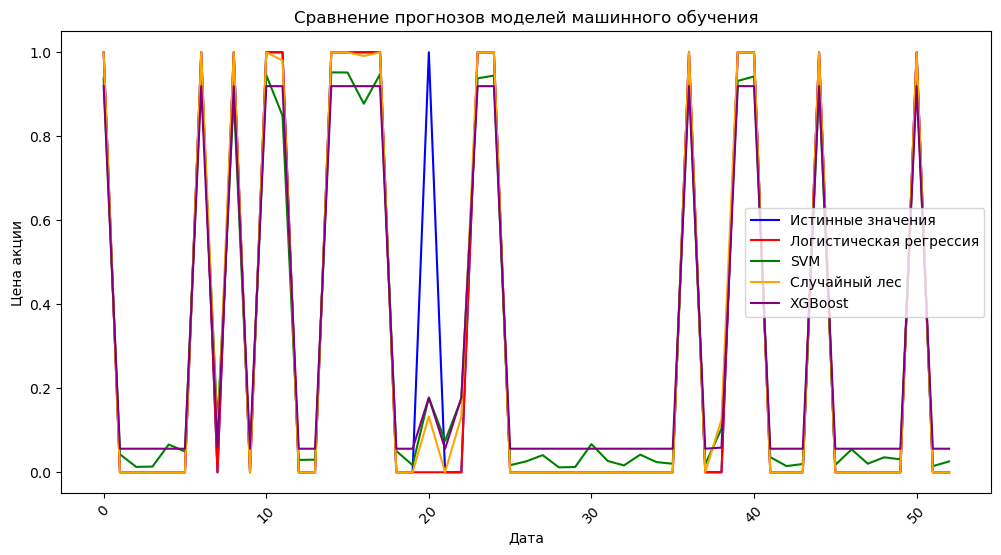

In [18]:
import matplotlib.pyplot as plt

# Визуализация результатов
plt.figure(figsize=(12, 6))

# Если y_test — это NumPy массив, создаем последовательность индексов для оси X
dates = range(len(y_test))

# Истинные значения (цены акций)
plt.plot(dates, y_test, label='Истинные значения', color='blue')

# Прогнозы для каждой модели
plt.plot(dates, y_pred_lr, label='Логистическая регрессия', color='red')
plt.plot(dates, y_pred_svm, label='SVM', color='green')
plt.plot(dates, y_pred_rf, label='Случайный лес', color='orange')
plt.plot(dates, y_pred_xg, label='XGBoost', color='purple')

# Настройка графика
plt.title('Сравнение прогнозов моделей машинного обучения')
plt.xlabel('Дата')
plt.ylabel('Цена акции')
plt.legend()
plt.xticks(rotation=45)  # Поворот подписей по оси X для улучшения читаемости
plt.show()


## Выводы
Обработка данных: Для обучения использовались только дата и цена акции, данные нормализованы с помощью стандартного скейлера.
Модель: SWM показала лучшие результаты по точности. Логистическая регрессия и др оказались менее эффективными для предсказания цен акций.
Настройка гиперпараметров: Использование кросс-валидации улучшило результаты моделей, особенно для логистической модели.
Сравнение моделей: Random Forest обеспечил точные прогнозы, в то время как логистическая регрессия и др показали значительные отклонения от реальных данных.
Анализ важности признаков: Random Forest позволил выявить ключевые признаки, влияющие на прогнозы.